In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.datasets import make_classification, make_blobs

from numpy.linalg import inv
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [5]:
def generate_data(T, n, d, n_class = 4, class_sep = 10, n_redundant = 0,
                  weights = None, distribution = 'gauss', method = "bounded", bound = 3):
    '''
    generates the sequence of {i_t,C_t} over time.

    INPUT :
    ***** FROM THE ARTICLE   *****
    - T: number if time step
    - n: number of users
    - d: number of features

    *****  IMPLEMENTATION DETAILS   *****
    - n_class : number of latent classes in the users
    - class_sep : distance between classes
    - n_redundant: number of redundant features
    - weights: repartition of samples between the classes

    OUPUT:
    list lists, each list is the context at time t and is made of three elements:
        - indice of the user picked
        - features if the user picked
        - array of the products available


    '''

    #we introduce here different cardinality for each class
    if weights == None:
        weights = np.ones((n_class))
        if n_class > 2:
            weights[0] = 2/n_class
            weights[1:] = (n_class-2)/(n_class*(n_class-1))
    weights = weights.tolist()

    if distribution == 'polygon':
    
        users_params = {"n_samples" : n, "n_features" : d, "n_informative" : d - n_redundant, "n_redundant" : n_redundant,
            "n_repeated" : 0, "n_classes": n_class,"n_clusters_per_class":1, "weights": weights,
            "flip_y":0.0, "class_sep": class_sep, "hypercube":None, "shift":0.0, "scale":1.0, "shuffle":True,
            "random_state":None}

        #build the matrix of users
        [users, users_labels] = make_classification(**users_params)
        
    else :
        
        users_params = {"n_samples" : n, "n_features" : d, "centers": n_class, "cluster_std" : 1/class_sep, 
                        "center_box" : (-10.0, 10.0), "shuffle" : True, "random_state" : None}
        [users, users_labels] = make_blobs(**users_params)
       
    
    #we normalize each row with L2 norm    
    users = users / (np.sum(np.abs(users)**2,axis=-1)**(1./2))[:, np.newaxis] 

    #build the matrix of product
    C = np.eye(d)

    output = []
    for t in range(T):
        i = np.random.randint(0, n)   #user picked   CHANGER DISTRIBUTION ?
        user_selected = users[i,:]
        item_number = np.random.randint(1,d)
        if method == "bounded":
            item_available = C[:,np.random.choice(d, bound, replace=False)]
        else:    
            item_available = C[:,np.random.choice(d, item_number, replace=False)]

        output += [[i, user_selected, np.matrix(item_available)]]

    return [np.matrix(users), output]


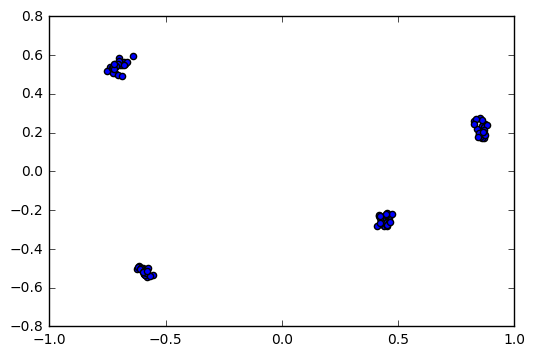

In [19]:
pca = PCA(n_components = 2)
T = 1
n = 100
d = 10
n_class = 5
users_ex = generate_data(T, n, d, n_class = 4, class_sep = 2, n_redundant = 0,
                  weights = None, distribution = 'gauss', method = "bounded", bound = 3)[0]

proj = pca.fit_transform(users_ex)
plt.scatter(proj[:,0], proj[:,1])


In [109]:
def Context_Aware_Clustering_of_Bandits(gamma, alpha, d, n, T, n_class=4):
    '''
    Implementation of the CAB algorithm presented in On Context-Dependent Clustering of Bandits
    :param gamma: the gap parameter: int
    :param alpha: list of length n, parameter used to calculate the standard confident bound (CB) for different users
    for the different periods. This parameter is called exploration parameter: list
    :param d: dimension of the context vectors: int
    :param n: number of different users: int
    :param T: number of period for the algorithm: int
    :return:
    '''

    if len(alpha) != T:
        raise ValueError('alpha should have a length = T')
        
    regret = []
    MSE_users = []
    choices= []
    best_choices =[]
    
    b_list = [np.matrix(np.zeros(d)).T for i in range(n)]  # Initialisation as a 0 column vector for every user
    #print('b_list[0]:',b_list[0].shape)
    M_list = [np.eye(d) for i in range(n)]  # Initialisation as the identity matrix for every user
    #print('M_list[0]:',M_list[0].shape)
    generation_tot = generate_data(T=T, n=n, d=d, n_class=n_class)
    #print('generation_tot:',generation_tot)
    
    data_generation = generation_tot[1]  # we receive the list of all the users that will be selected during the T
    # periods and their user feature
    users = generation_tot[0]  # the matrix containing all the user features
    #print('users.shape:',users.shape)
    CB = np.zeros((n, d))  # Row corresponding to users and columns to the items
    
    for t in range(T):
        if t%500 ==0 :
            print('tour n° ' + str(t))
            
        # filling the CB Matrix
        for i in range(n):
            for k in range(d):
                CB[i, k] = alpha[t]*math.sqrt(inv(M_list[i])[k,k]) #the dot product in the article is equivalent to this       
        
        w_list = [inv(M_list[i]) @ b_list[i] for i in range(n)]  # w_list[i] is the vector for the i-th user updated
        
        #We compute the MSE for monitoring
        MSE_users += [sum([float(np.dot((users[i,:].T-w_list[i]).T,users[i,:].T-w_list[i])) for i in range(n)])]
        
        #We receive the data
        i_t, u_i_t, C_t = data_generation[t]
        u_i_t = np.matrix(u_i_t).T
        K = C_t.shape[1]  # number of items in the context
        dico_t = {}  # for each item will contain list of neighbors
        
        
        ##### ATTENTION ICI LA MODIF !!!!!!
        w_dico_N_K = {}
        CB_dico_N_K= {}
        #We compute the neighborhood
        for k in range(K):
            num_item = np.where(C_t[:, k] == 1.)[0][0]
            # num_item is the absolute item number among all the items, but it is the k-th item in the context at period
            # t
            neigh_k_it = []
            
            # Creation of the neighborhood for each item
            for j in range(n):
                if abs(w_list[i_t].T @ C_t[:, k] - w_list[j].T @ C_t[:, k])[0, 0] <= CB[i_t, num_item] + CB[j, num_item]:
                        neigh_k_it.append(j)
                else : 
                    print('pas ajout')
            w_dico_N_K[num_item] = sum([w_list[neigh] for neigh in neigh_k_it])/len(neigh_k_it)
            CB_dico_N_K[num_item] = sum([CB[j, num_item] for j in neigh_k_it])/len(neigh_k_it)
            #print('CB_dico_N_K[num_item]:',CB_dico_N_K[num_item])
            dico_t[num_item] = neigh_k_it
            #print('len(neigh_k_it):',len(neigh_k_it))
            
        # Part for the item recommendation
        maxi = - math.inf
        indice_contexte = 0
        for k in range(K):
            num_item = np.where(C_t[:, k] == 1.)[0][0]
            if num_item in w_dico_N_K.keys():
                a = (w_dico_N_K[num_item].T @ C_t[:, k] + CB_dico_N_K[num_item])[0, 0]
                if a >= maxi:
                    maxi = a
                    indice_contexte = k  # this is the indice in the context window that will be proposed
        item_propos = np.where(C_t[:, indice_contexte] == 1.)[0][0]  # this is the item that will be proposed
        choices += [item_propos]
        
        y_t = (u_i_t.T @ C_t[:, indice_contexte])[0, 0] + np.random.normal(0, 0.001)  # check std here
        # y_t is the payoff for the user i given the u_i feature vector and the item chosen
        
        #we compute regret
        best_choice = np.argmax(u_i_t.T @ C_t) 
        #print('best_choice:', best_choice)
        best_choices += [np.where(C_t[:, best_choice] == 1.)[0][0]]
        #print('best_choices:', best_choices)
        #print('----')
        regret += [float(u_i_t.T @ C_t[:, best_choice] - u_i_t.T @ C_t[:, indice_contexte])]
        
              
        if CB[i_t, item_propos] >= gamma/4:
            M_list[i_t] = M_list[i_t] + C_t[:, indice_contexte] @ C_t[:, indice_contexte].T
            b_list[i_t] = b_list[i_t] + y_t*C_t[:, indice_contexte]
        else:
            for neigh in dico_t[item_propos]:
                if CB[neigh, item_propos] < gamma/4:
                    M_list[neigh] = M_list[neigh] + C_t[:, indice_contexte] @ C_t[:, indice_contexte].T
                    b_list[neigh] = b_list[neigh] + y_t * C_t[:, indice_contexte]
    return [users, w_list, regret, MSE_users, choices, best_choices]

In [23]:
def three_D_eye_matrix(dim1,dim2):
    res = np.zeros((dim1,dim2,dim2))
    for i in range(dim1):
        res[i] = np.eye(dim2,dim2)
    return res

In [152]:
def Context_Aware_Clustering_of_Bandits_new(gamma, alpha, d, n, T, n_class=4, verbose=False):
    '''
    Implementation of the CAB algorithm presented in On Context-Dependent Clustering of Bandits
    :param gamma: the gap parameter: int
    :param alpha: list of length n, parameter used to calculate the standard confident bound (CB) for different users
    for the different periods. This parameter is called exploration parameter: list
    :param d: dimension of the context vectors: int
    :param n: number of different users: int
    :param T: number of period for the algorithm: int
    :param verbose: more information print
    :return:
    '''

    if len(alpha) != T:
        raise ValueError('alpha should have a length = T')
        
    regret = []
    MSE_users = []
    choices= []
    best_choices =[]
    b_matrix = np.zeros(shape = (n,d,1))
    M_matrix = three_D_eye_matrix(n,d)
    generation_data = generate_data(T=T, n=n, d=d, n_class=n_class)
    (users_matrix, data_generation) = (generation_data[0], generation_data[1])
    CB = np.zeros((n, d))
    w_matrix = np.zeros(shape = (n,d,1))
    
    updates = []
    neighbors_story = []
    
    for t in range(T):
        if t%500 ==0 :
            print("##################")
            print("##################")
            print('tour n° ' + str(t))
            print("##################")
            print("##################")
            
        for i in range(n):
            for k in range(d):
                # d columns correspond to the different items (absolute numbers !)
                CB[i, k] = alpha[t]*math.sqrt(inv(M_matrix[i])[k,k])
            w_matrix[i] = inv(M_matrix[i]) @ b_matrix[i]
            #if (verbose == True) and i < 10:
               # if t%500 == 0:
            #        print('inv(M_matrix[%i]):'%i,inv(M_matrix[i]))
             #       print('b_matrix[%i]:'%i,b_matrix[i])
                     #print('w_matrix[%i]:'%i, w_matrix[i])

        
        MSE_users += [[float(np.dot((users_matrix[i,:].T-w_matrix[i]).T,users_matrix[i,:].T-w_matrix[i])) for i in range(n)]]
        
        i_t, u_i_t, C_t = data_generation[t]
        u_i_t = np.matrix(u_i_t).T
        K = C_t.shape[1]  # number of items in the context
        dico_t = {}  # for each item will contain list of neighbors
        
        if verbose == True:
            if t%500 == 0:
                print('sanity check data generation part -----')
                print('i_t:',i_t)
                #print('u_i_t.shape',u_i_t.shape)
                #print('C_t',C_t)
                print('CB', CB)
        
        w_dico_N_K = {}
        CB_dico_N_K= {}

        for k in range(K):
            num_item = np.where(C_t[:, k] == 1.)[0][0]
            neigh_k_it = []
            
            # Creation of the neighborhood for each item
            for j in range(n):
                if t%500 == 0:
                    if (verbose == True) and (j<10):
                        print('@@ Neighborhood Sanity Check @@')
                        print('Left part of the equation:',abs(w_matrix[i_t].T @ C_t[:, k] - w_matrix[j].T @ C_t[:, k])[0, 0])
                        print('CB[i_t, num_item] + CB[j, num_item]:', CB[i_t, num_item] + CB[j, num_item])
                if abs(w_matrix[i_t].T @ C_t[:, k] - w_matrix[j].T @ C_t[:, k])[0, 0] <= CB[i_t, num_item] + CB[j, num_item]:
                        neigh_k_it.append(j)
                  
            w_dico_N_K[num_item] = sum([w_matrix[neigh] for neigh in neigh_k_it])/len(neigh_k_it)
            #if t%500 == 0:
            #    print('##########Sanity check neighbors:',len(neigh_k_it))
            #    print('sum([w_matrix[neigh] for neigh in neigh_k_it]):',sum([w_matrix[neigh] for neigh in neigh_k_it]))
            #    print('w_dico_N_K[num_item]:',w_dico_N_K[num_item])
            CB_dico_N_K[num_item] = sum([CB[j, num_item] for j in neigh_k_it])/len(neigh_k_it)
            
            dico_t[num_item] = neigh_k_it
        neighbors_story += [len(neigh_k_it)]
            
        # Part for the item recommendation
        maxi = - math.inf
        indice_contexte = 0
        for k in range(K):
            num_item = np.where(C_t[:, k] == 1.)[0][0]
            if num_item in w_dico_N_K.keys():
                #if t%500 == 0:
                #    print('aaaaaaaaa sanity item recommandation aaaaaaaa')
                #    print(CB_dico_N_K[num_item])
                #    print(w_dico_N_K[num_item].T @ C_t[:, k] + CB_dico_N_K[num_item])
                a = (w_dico_N_K[num_item].T @ C_t[:, k] + CB_dico_N_K[num_item])[0, 0]
                if a >= maxi:
                    maxi = a
                    indice_contexte = k  # this is the indice in the context window that will be proposed
        item_propos = np.where(C_t[:, indice_contexte] == 1.)[0][0]  # this is the item that will be proposed
        choices += [item_propos]
        
        y_t = (u_i_t.T @ C_t[:, indice_contexte])[0, 0] + np.random.normal(0, 0.001)  # check std here
        # y_t is the payoff for the user i given the u_i feature vector and the item chosen
            
        best_choice = np.argmax(u_i_t.T @ C_t) 
        best_choices += [np.where(C_t[:, best_choice] == 1.)[0][0]]
        regret += [float(u_i_t.T @ C_t[:, best_choice] - u_i_t.T @ C_t[:, indice_contexte])]
        
              
        if CB[i_t, item_propos] >= gamma/4:
            M_matrix[i_t] = M_matrix[i_t] + C_t[:, indice_contexte] @ C_t[:, indice_contexte].T  
            b_matrix[i_t] = b_matrix[i_t] + y_t*C_t[:, indice_contexte]
            updates += [0]
            
        else:
            up = 0
            for neigh in dico_t[item_propos]:
                if CB[neigh, item_propos] < gamma/4:
                    M_matrix[neigh] = M_matrix[neigh] + C_t[:, indice_contexte] @ C_t[:, indice_contexte].T
                    b_matrix[neigh] = b_matrix[neigh] + y_t * C_t[:, indice_contexte]
                    up += 1
            updates += [up]
    return [users_matrix, w_matrix, regret, MSE_users, choices, best_choices, updates, neighbors_story]
        
            
    
    
    

In [91]:
d=4
n=10
T=20000
[u_4_10, w_4_10, regret_4_10, MSE_4_10, choices_4_10, best_choices_4_10] = Context_Aware_Clustering_of_Bandits_new(gamma=0.05,
                                                          alpha= [math.sqrt(d*math.log(t)) for t in range(1,T+1)],
                                                          d=d,n=n,T=T, verbose = True)

##################
##################
tour n° 0
##################
##################
inv(M_matrix[0]): [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
b_matrix[0]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
w_matrix[0]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
inv(M_matrix[1]): [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
b_matrix[1]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
w_matrix[1]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
inv(M_matrix[2]): [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
b_matrix[2]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
w_matrix[2]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
inv(M_matrix[3]): [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
b_matrix[3]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
w_matrix[3]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
inv(M_matrix[4]): [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
b_matrix[4]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
w_matrix[4]: [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
inv(M_matrix[5]): [

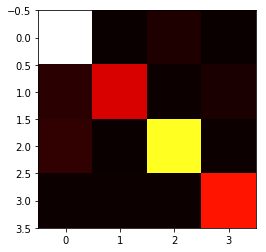

In [92]:
plt.imshow(confusion_matrix(best_choices_4_10, choices_4_10),cmap='hot', interpolation='nearest')

In [120]:
confusion_matrix(best_choices_4_10, choices_4_10)

array([[7317,   26,  269,   33],
       [ 390, 2290,   80,  223],
       [ 471,   37, 5705,   72],
       [  63,   58,   59, 2907]])

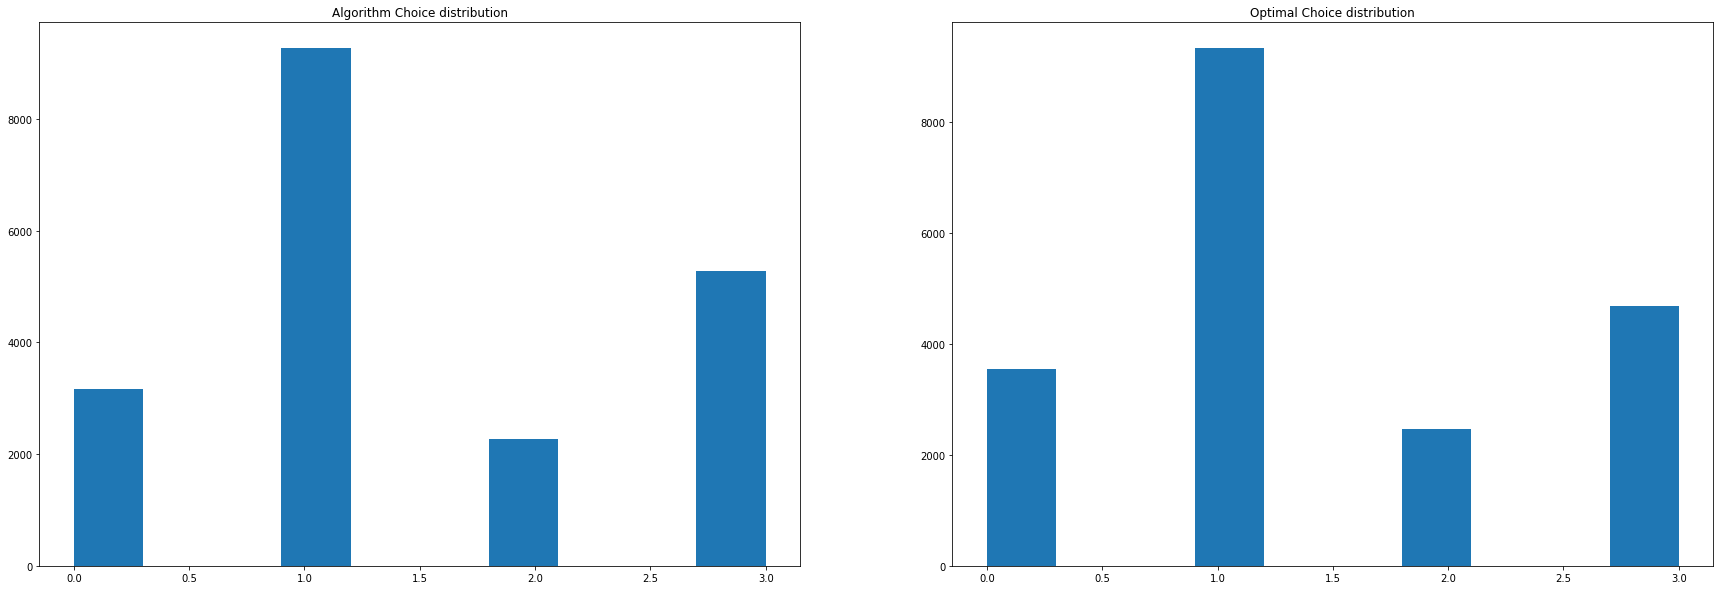

In [134]:
plt.figure(figsize=(20,20))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,10))
ax1.hist(choices_4_10)
ax1.set_title('Algorithm Choice distribution')
ax2.hist(best_choices_4_10) # bins=np.arange(-0.5,8.5))
ax2.set_title('Optimal Choice distribution')
plt.show()

plt.scatter([u[i,0] for i in range(20)],[u[i,1] for i in range(20)])

0.91095


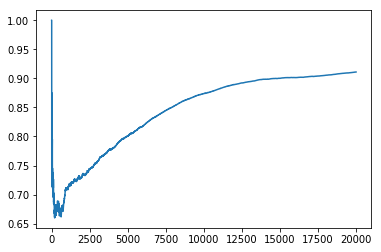

In [122]:
regret_arr_4_10 = np.array(regret_4_10)
print(np.sum(regret_arr_4_10 == 0)/np.size(regret_arr_4_10))
plt.plot(np.cumsum(regret_arr_4_10 == 0)/np.arange(1,T+1))

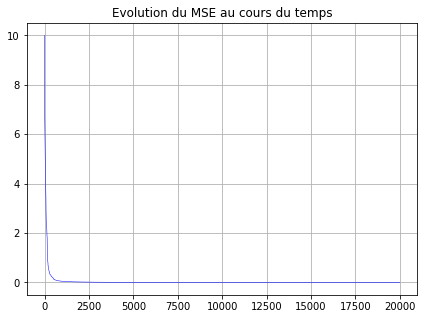

In [123]:
plt.figure(figsize=(7,5))
plt.title('Evolution du MSE au cours du temps')
plt.grid()
plt.plot(MSE_4_10, c='b', linewidth=0.5)

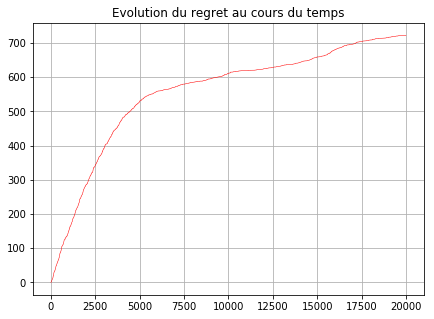

In [125]:
#on affiche le regret
plt.figure(figsize=(7,5))
plt.title('Evolution du regret au cours du temps')
plt.grid()
plt.plot(np.cumsum(np.array(regret_4_10)), c='r', linewidth=0.5)

## Comparaison avec d'autres valeurs de Gamma pour voir si vitesse de convergence et performance modifiée

In [128]:
d=4
n=10
T=20000
[u_4_10_2, w_4_10_2, regret_4_10_2, MSE_4_10_2, choices_4_10_2, best_choices_4_10_2] = Context_Aware_Clustering_of_Bandits_new(
                                            gamma=0.25, alpha= [math.sqrt(d*math.log(t)) for t in range(1,T+1)],
                                            d=d,n=n,T=T, verbose = False)

##################
##################
tour n° 0
##################
##################
##################
##################
tour n° 500
##################
##################
##################
##################
tour n° 1000
##################
##################
##################
##################
tour n° 1500
##################
##################
##################
##################
tour n° 2000
##################
##################
##################
##################
tour n° 2500
##################
##################
##################
##################
tour n° 3000
##################
##################
##################
##################
tour n° 3500
##################
##################
##################
##################
tour n° 4000
##################
##################
##################
##################
tour n° 4500
##################
##################
##################
##################
tour n° 5000
##################
##################
##################
######

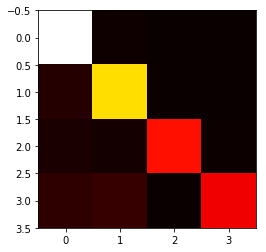

In [130]:
plt.imshow(confusion_matrix(best_choices_4_10_2, choices_4_10_2),cmap='hot', interpolation='nearest')

In [132]:
confusion_matrix(best_choices_4_10_2, choices_4_10_2)

array([[7411,  103,   30,   37],
       [ 323, 5161,   17,   27],
       [ 213,  147, 2896,   59],
       [ 438,  525,   27, 2586]])

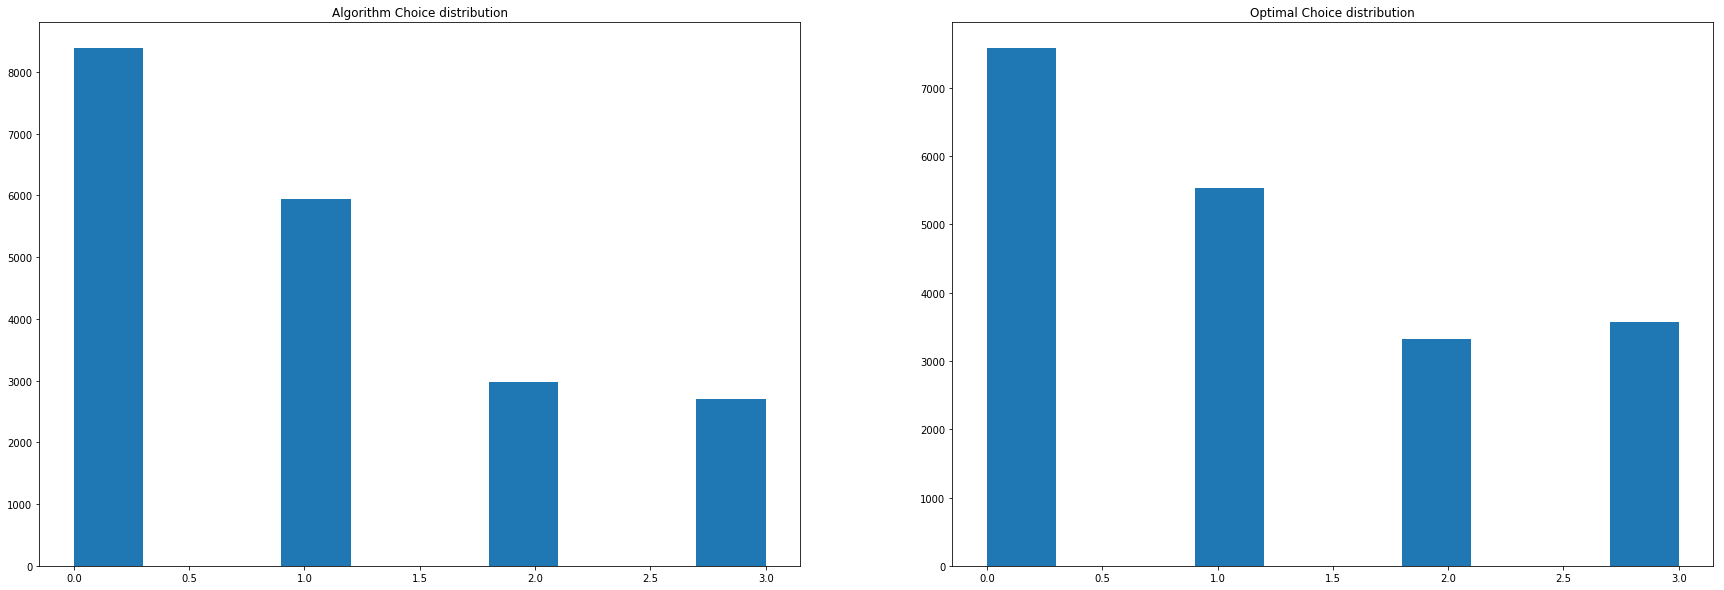

In [153]:
plt.figure(figsize=(20,20))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,10))
ax1.hist(choices_4_10_2)
ax1.set_title('Algorithm Choice distribution')
ax2.hist(best_choices_4_10_2) # bins=np.arange(-0.5,8.5))
ax2.set_title('Optimal Choice distribution')
plt.show()

0.9027


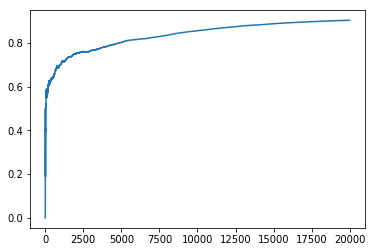

In [155]:
regret_arr_4_10_2 = np.array(regret_4_10_2)
print(np.sum(regret_arr_4_10_2 == 0)/np.size(regret_arr_4_10_2))
plt.plot(np.cumsum(regret_arr_4_10_2 == 0)/np.arange(1,T+1))

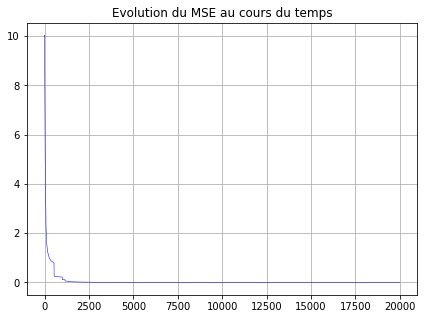

In [156]:
plt.figure(figsize=(7,5))
plt.title('Evolution du MSE au cours du temps')
plt.grid()
plt.plot(MSE_4_10_2, c='b', linewidth=0.5)

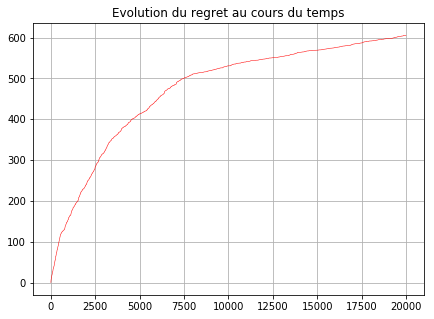

In [157]:
#on affiche le regret
plt.figure(figsize=(7,5))
plt.title('Evolution du regret au cours du temps')
plt.grid()
plt.plot(np.cumsum(np.array(regret_4_10_2)), c='r', linewidth=0.5)

In [158]:
d=4
n=10
T=20000
[u_4_10_3, w_4_10_3, regret_4_10_3, MSE_4_10_3, choices_4_10_3, best_choices_4_10_3] = Context_Aware_Clustering_of_Bandits_new(
                                            gamma=0.75, alpha= [math.sqrt(d*math.log(t)) for t in range(1,T+1)],
                                            d=d,n=n,T=T, verbose = False)

##################
##################
tour n° 0
##################
##################
##################
##################
tour n° 500
##################
##################
##################
##################
tour n° 1000
##################
##################
##################
##################
tour n° 1500
##################
##################
##################
##################
tour n° 2000
##################
##################
##################
##################
tour n° 2500
##################
##################
##################
##################
tour n° 3000
##################
##################
##################
##################
tour n° 3500
##################
##################
##################
##################
tour n° 4000
##################
##################
##################
##################
tour n° 4500
##################
##################
##################
##################
tour n° 5000
##################
##################
##################
######

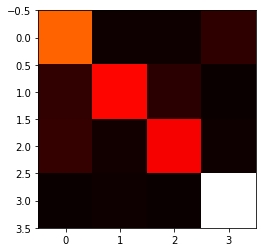

In [160]:
plt.imshow(confusion_matrix(best_choices_4_10_3, choices_4_10_3),cmap='hot', interpolation='nearest')

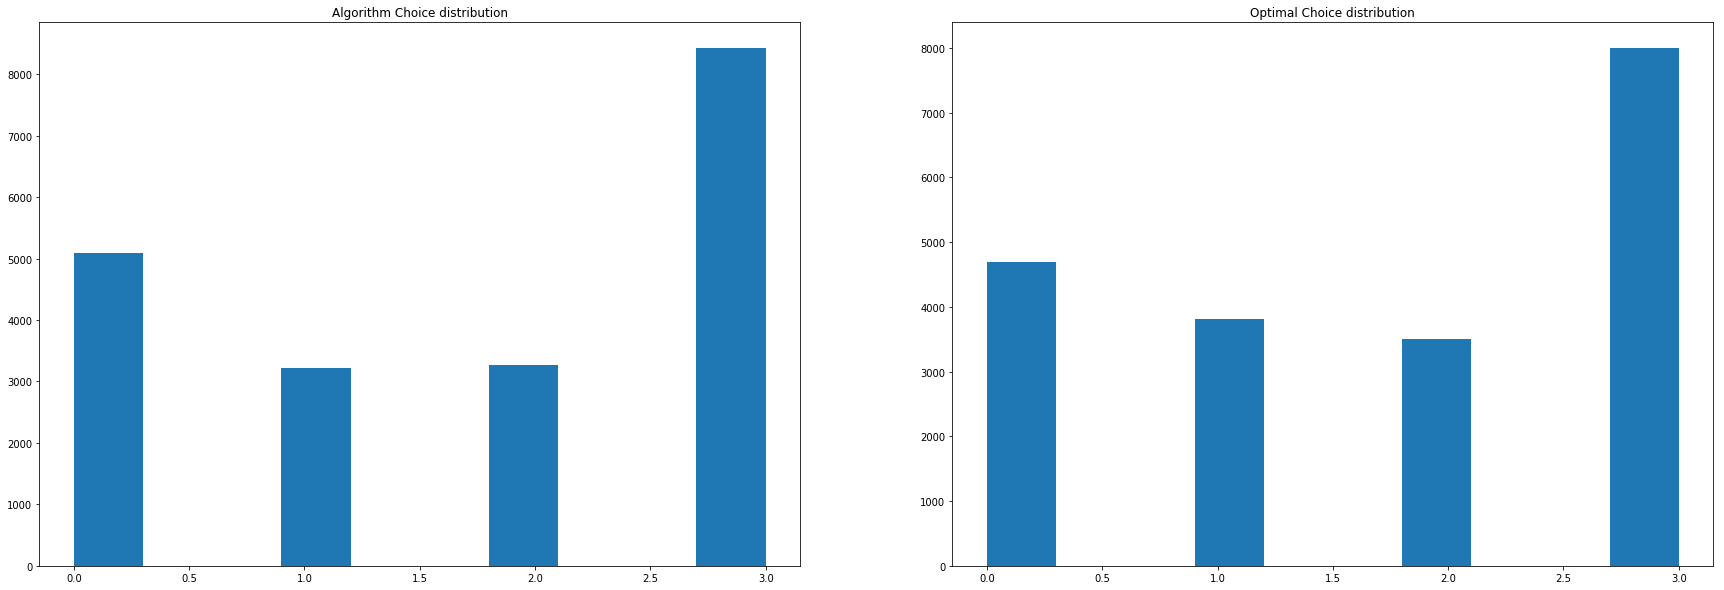

In [162]:
plt.figure(figsize=(20,20))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,10))
ax1.hist(choices_4_10_3)
ax1.set_title('Algorithm Choice distribution')
ax2.hist(best_choices_4_10_3) # bins=np.arange(-0.5,8.5))
ax2.set_title('Optimal Choice distribution')
plt.show()

0.88375


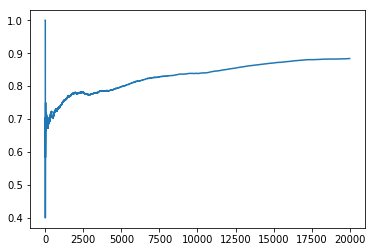

In [164]:
regret_arr_4_10_3 = np.array(regret_4_10_3)
print(np.sum(regret_arr_4_10_3 == 0)/np.size(regret_arr_4_10_3))
plt.plot(np.cumsum(regret_arr_4_10_3 == 0)/np.arange(1,T+1))

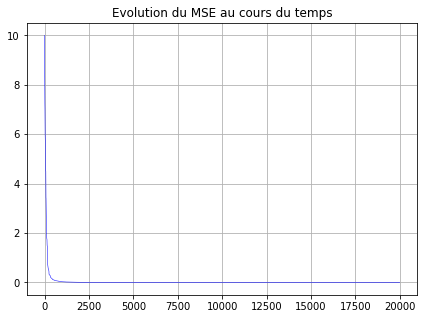

In [165]:
plt.figure(figsize=(7,5))
plt.title('Evolution du MSE au cours du temps')
plt.grid()
plt.plot(MSE_4_10_3, c='b', linewidth=0.5)

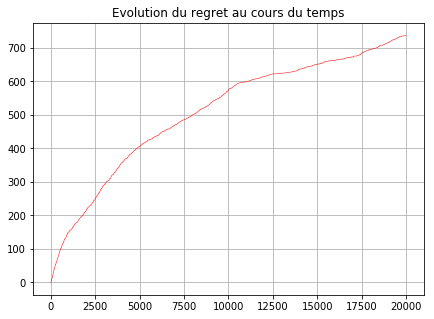

In [166]:
#on affiche le regret
plt.figure(figsize=(7,5))
plt.title('Evolution du regret au cours du temps')
plt.grid()
plt.plot(np.cumsum(np.array(regret_4_10_3)), c='r', linewidth=0.5)

# Comparaison différents gamma

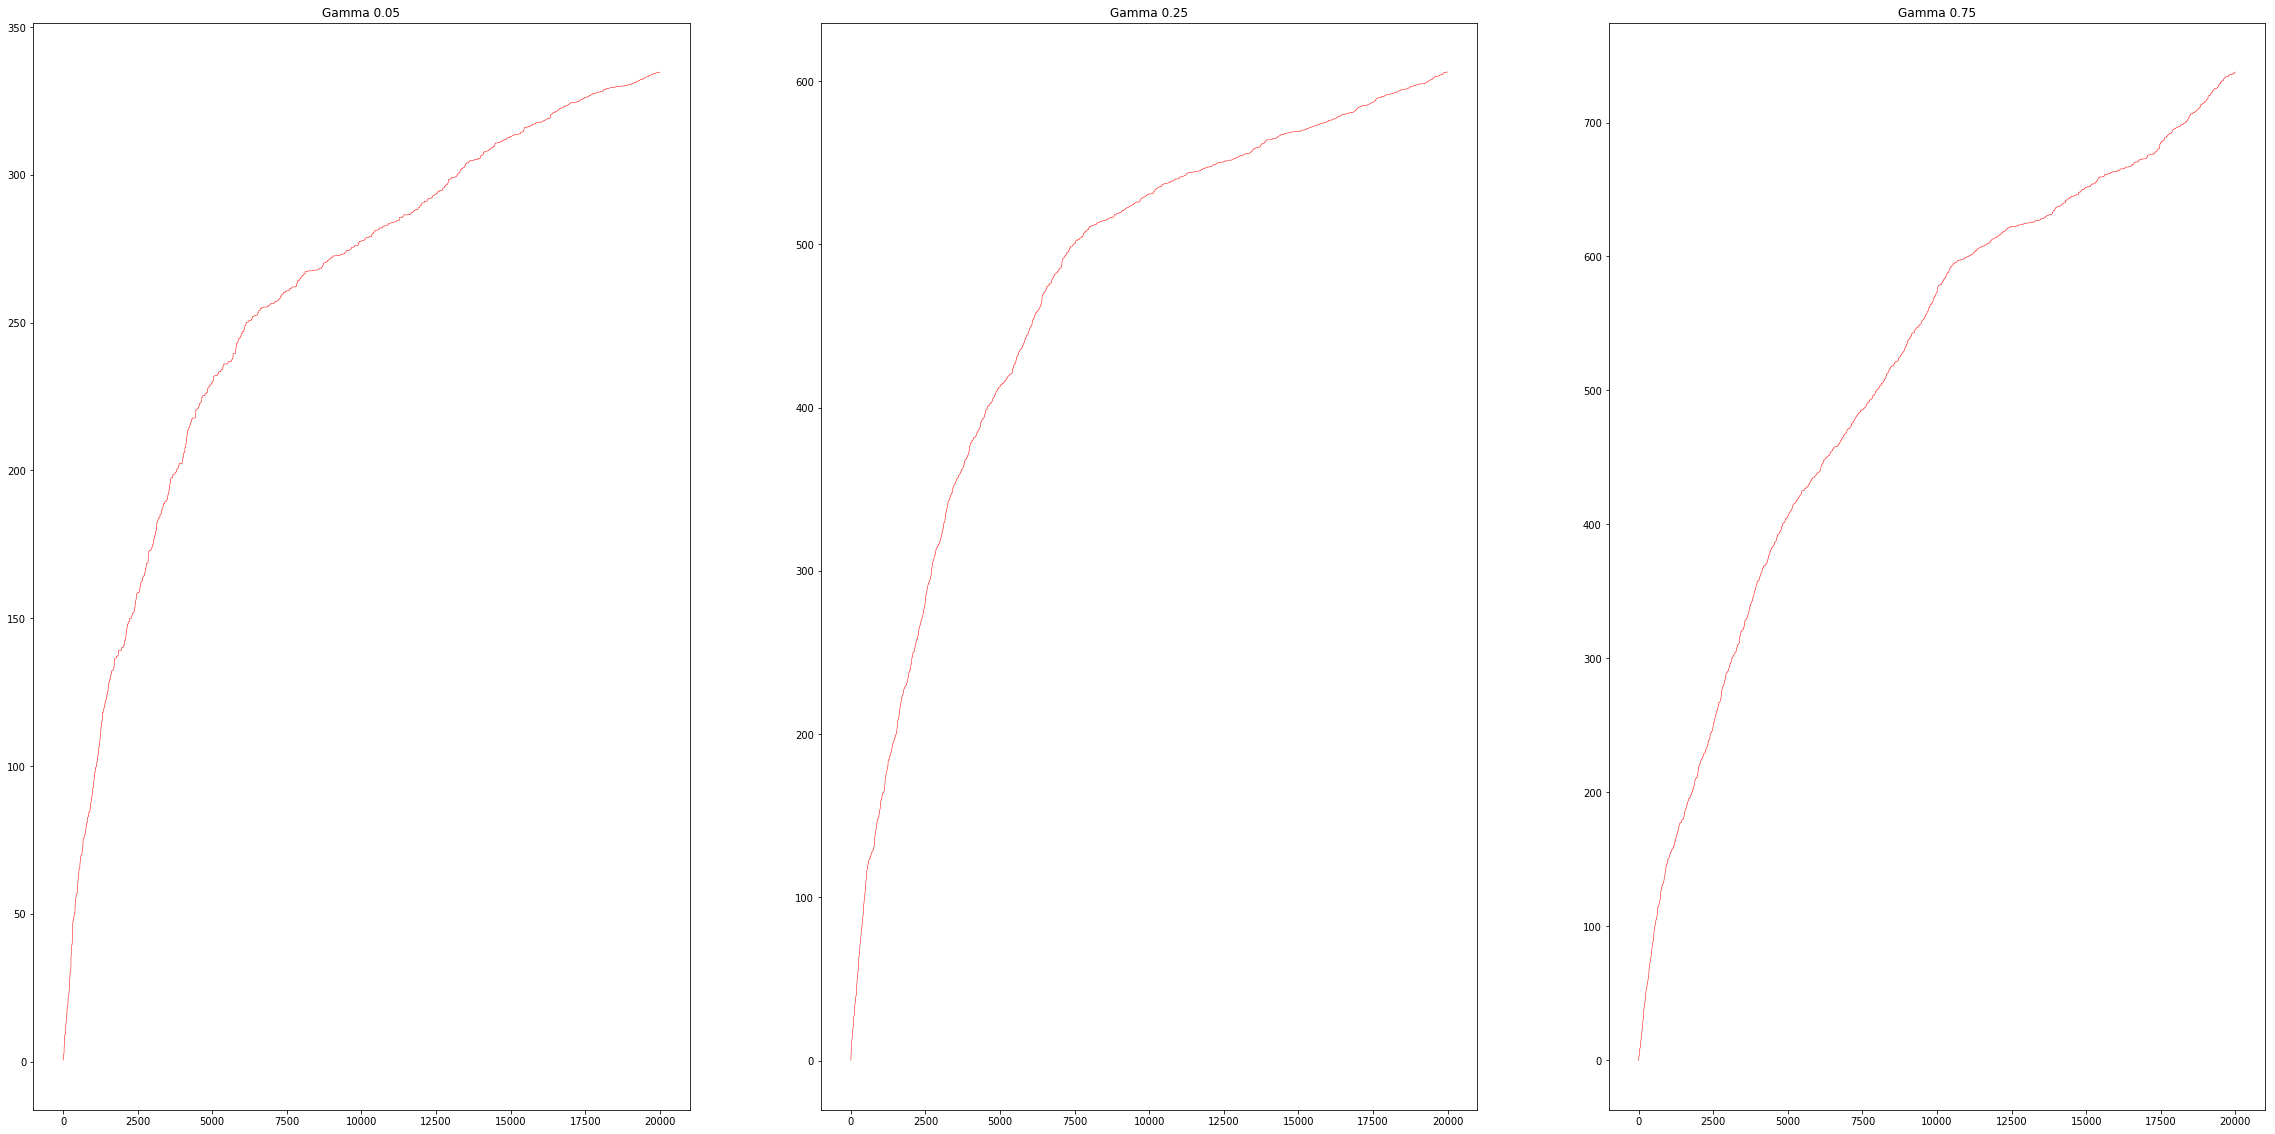

In [176]:
# pour regret 
plt.figure(figsize=(40,40))
f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(40,20))
ax1.plot(np.cumsum(np.array(regret_4_10)), c='r', linewidth=0.5)
ax1.set_title('Gamma 0.05')
ax2.plot(np.cumsum(np.array(regret_4_10_2)), c='r', linewidth=0.5)
ax2.set_title('Gamma 0.25')
ax3.plot(np.cumsum(np.array(regret_4_10_3)), c='r', linewidth=0.5)
ax3.set_title('Gamma 0.75')
plt.show()

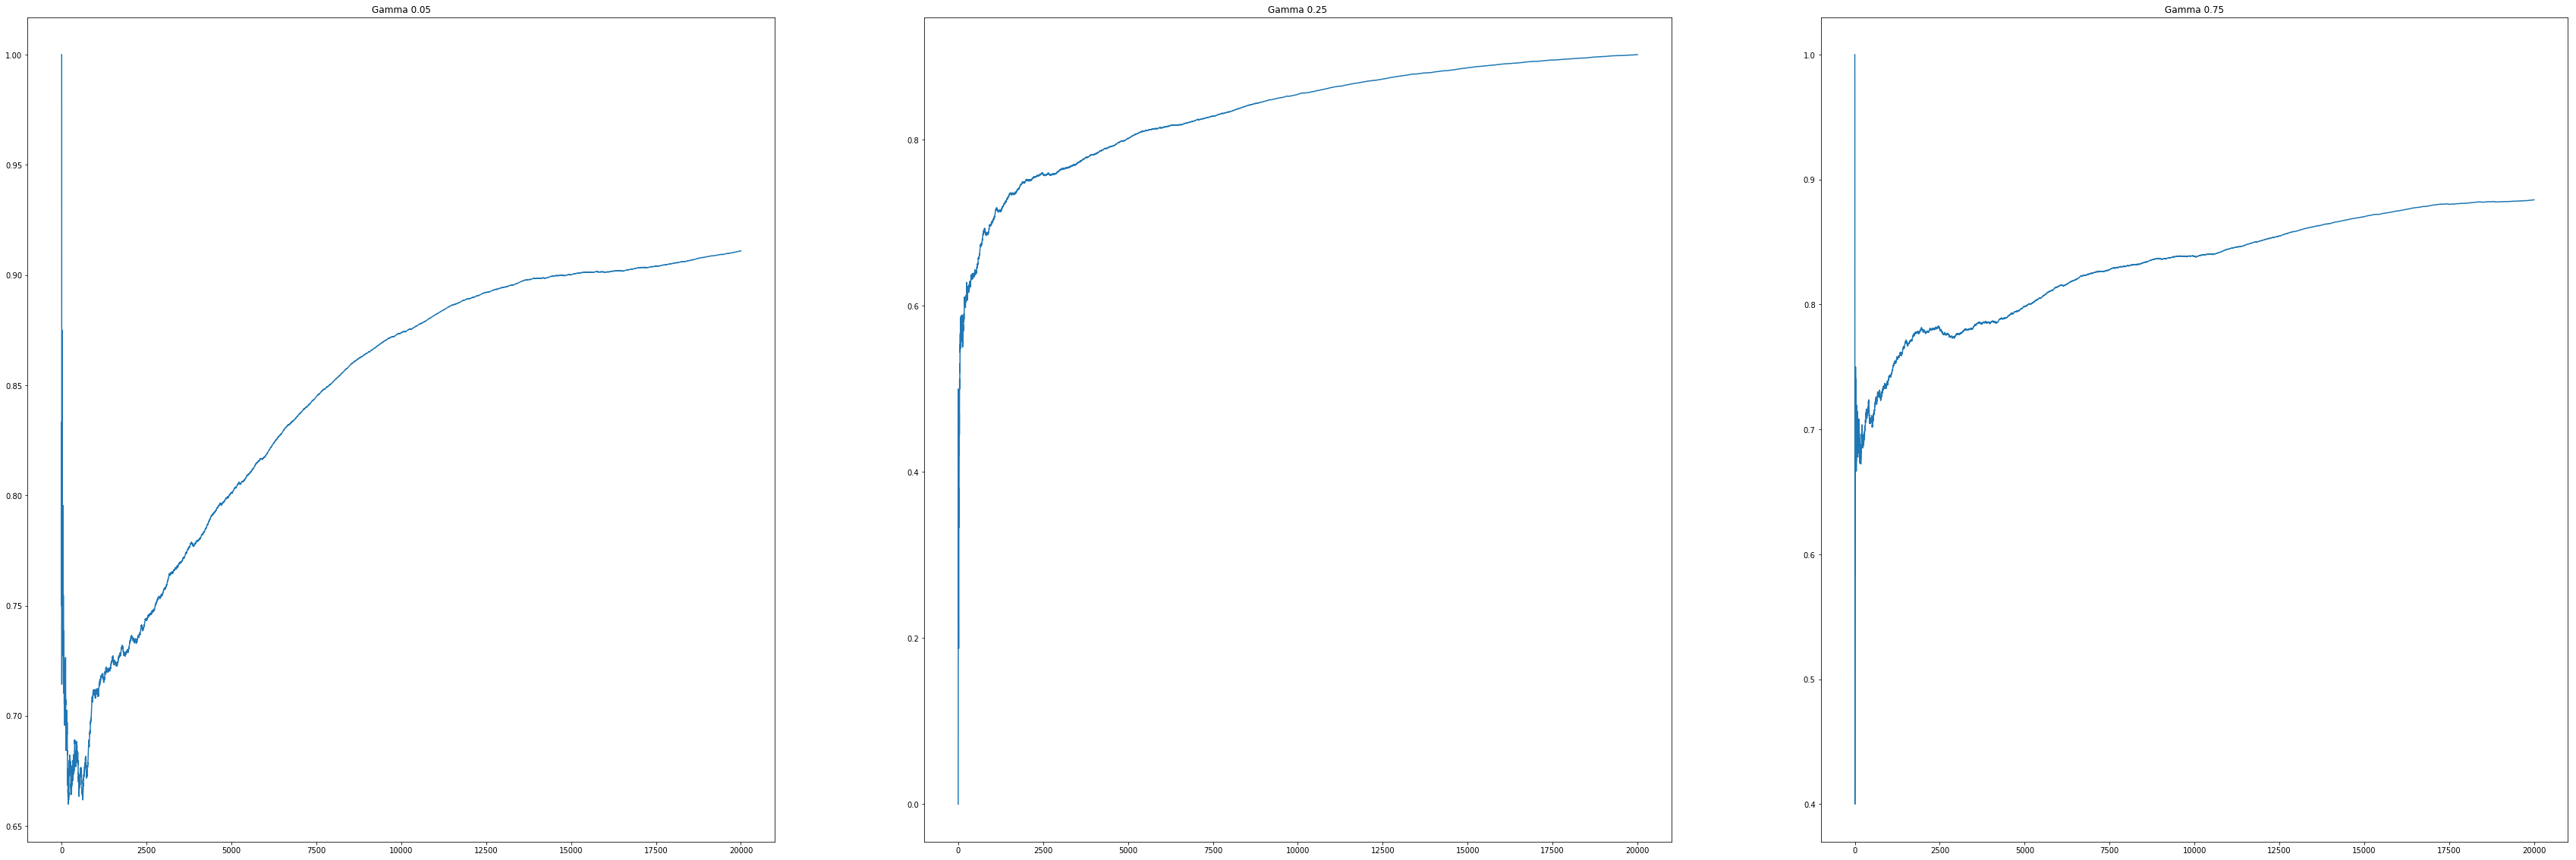

In [182]:
# regret cumulé moyen
plt.figure(figsize=(100,100))
f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(60,20))
ax1.plot(np.cumsum(regret_arr_4_10 == 0)/np.arange(1,T+1))
ax1.set_title('Gamma 0.05')
ax2.plot(np.cumsum(regret_arr_4_10_2 == 0)/np.arange(1,T+1))
ax2.set_title('Gamma 0.25')
ax3.plot(np.cumsum(regret_arr_4_10_3 == 0)/np.arange(1,T+1))
ax3.set_title('Gamma 0.75')
plt.show()

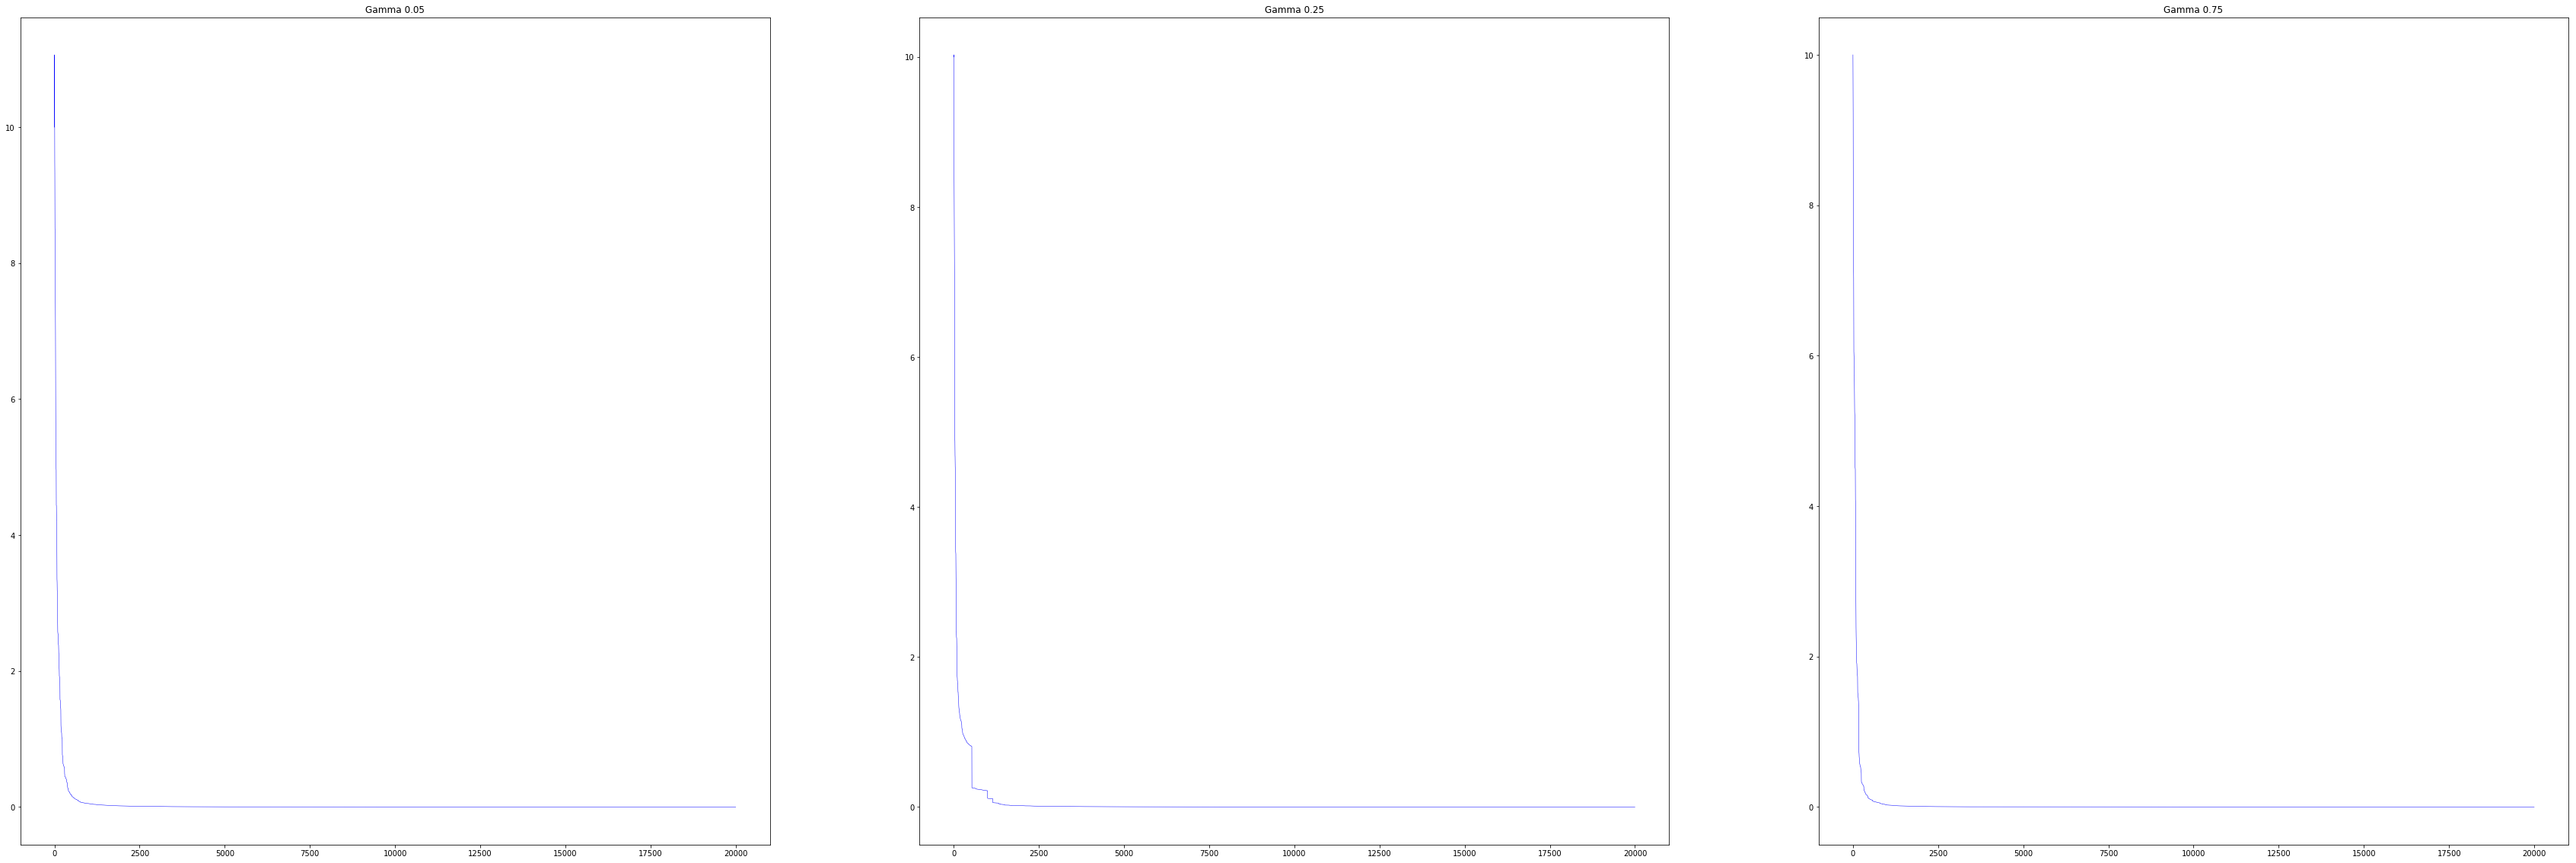

In [183]:
# regret cumulé moyen
plt.figure(figsize=(100,100))
f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(60,20))
ax1.plot(MSE_4_10, c='b', linewidth=0.5)
ax1.set_title('Gamma 0.05')
ax2.plot(MSE_4_10_2, c='b', linewidth=0.5)
ax2.set_title('Gamma 0.25')
ax3.plot(MSE_4_10_3, c='b', linewidth=0.5)
ax3.set_title('Gamma 0.75')
plt.show()

# Expé en grande dimension

In [136]:
d=25
n=100
T=50000
[u_LASTFM, w_LASTFM, regret_LASTFM, MSE_LASTFM, choices_LASTFM, best_choices_LASTFM] = Context_Aware_Clustering_of_Bandits_new(
                                            gamma=0.1, alpha= [math.sqrt(d*math.log(t)) for t in range(1,T+1)],
                                            d=d,n=n,T=T, verbose = False)

##################
##################
tour n° 0
##################
##################
##################
##################
tour n° 500
##################
##################
##################
##################
tour n° 1000
##################
##################
##################
##################
tour n° 1500
##################
##################
##################
##################
tour n° 2000
##################
##################
##################
##################
tour n° 2500
##################
##################
##################
##################
tour n° 3000
##################
##################
##################
##################
tour n° 3500
##################
##################
##################
##################
tour n° 4000
##################
##################
##################
##################
tour n° 4500
##################
##################
##################
##################
tour n° 5000
##################
##################
##################
######

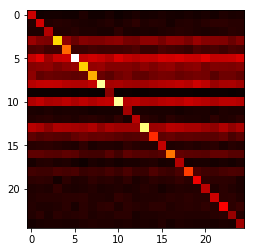

In [137]:
plt.imshow(confusion_matrix(best_choices_LASTFM, choices_LASTFM),cmap='hot', interpolation='nearest')

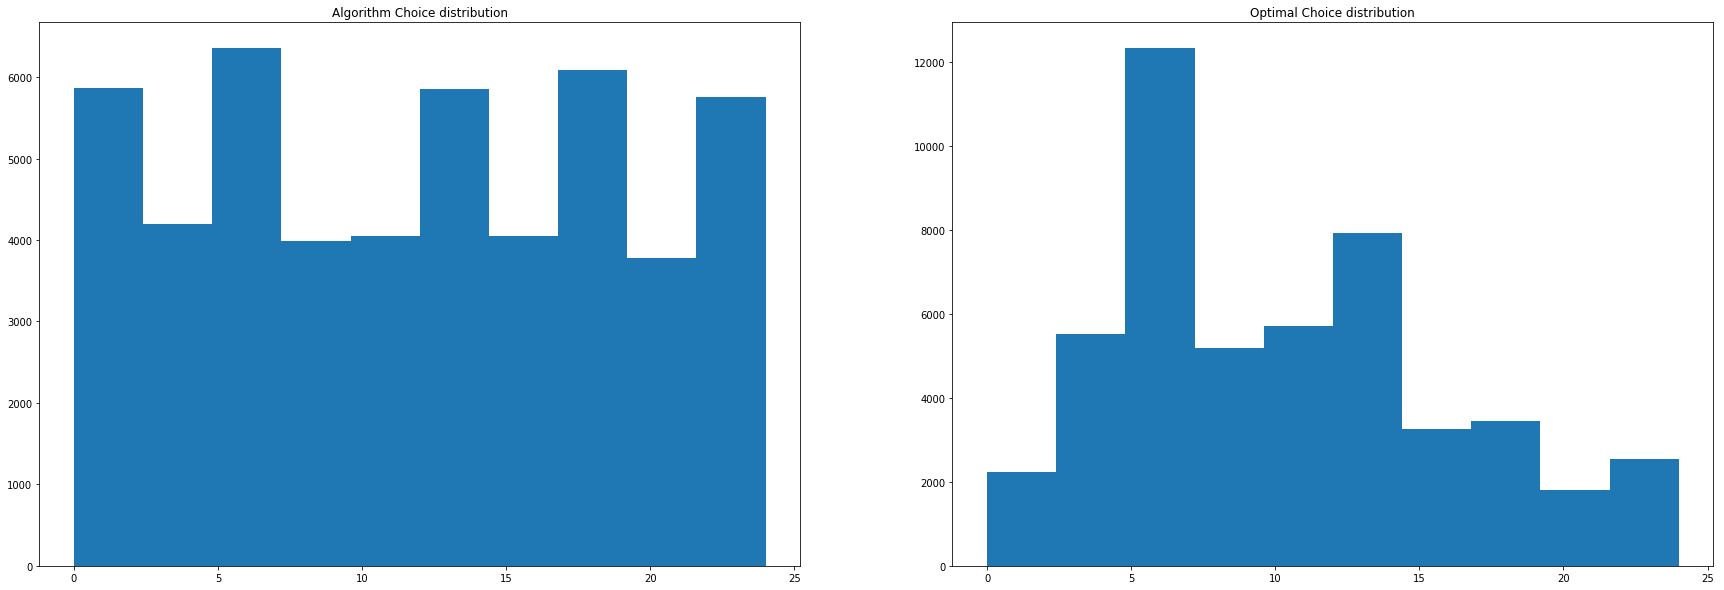

In [138]:
plt.figure(figsize=(20,20))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,10))
ax1.hist(choices_LASTFM)
ax1.set_title('Algorithm Choice distribution')
ax2.hist(best_choices_LASTFM) # bins=np.arange(-0.5,8.5))
ax2.set_title('Optimal Choice distribution')
plt.show()

0.16328


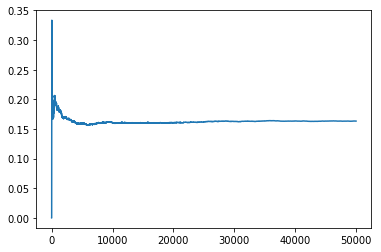

In [141]:
regret_arr_LASTFM = np.array(regret_LASTFM)
print(np.sum(regret_arr_LASTFM == 0)/np.size(regret_arr_LASTFM))
plt.plot(np.cumsum(regret_arr_LASTFM == 0)/np.arange(1,T+1))

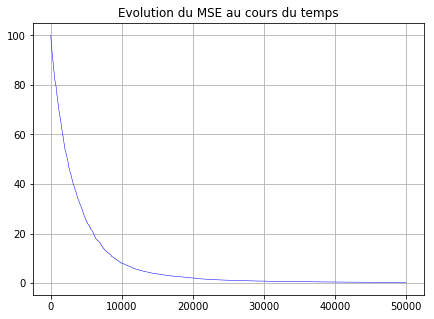

In [142]:
plt.figure(figsize=(7,5))
plt.title('Evolution du MSE au cours du temps')
plt.grid()
plt.plot(MSE_LASTFM, c='b', linewidth=0.5)

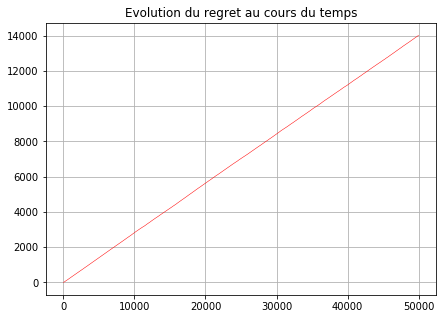

In [143]:
#on affiche le regret
plt.figure(figsize=(7,5))
plt.title('Evolution du regret au cours du temps')
plt.grid()
plt.plot(np.cumsum(np.array(regret_LASTFM)), c='r', linewidth=0.5)

In [144]:
d=25
n=50
T=50000
[u_25_50, w_25_50, regret_25_50, MSE_25_50, choices_25_50, best_choices_25_50] = Context_Aware_Clustering_of_Bandits_new(
                                            gamma=0.1, alpha= [math.sqrt(d*math.log(t)) for t in range(1,T+1)],
                                            d=d,n=n,T=T, verbose = False)

##################
##################
tour n° 0
##################
##################
##################
##################
tour n° 500
##################
##################
##################
##################
tour n° 1000
##################
##################
##################
##################
tour n° 1500
##################
##################
##################
##################
tour n° 2000
##################
##################
##################
##################
tour n° 2500
##################
##################
##################
##################
tour n° 3000
##################
##################
##################
##################
tour n° 3500
##################
##################
##################
##################
tour n° 4000
##################
##################
##################
##################
tour n° 4500
##################
##################
##################
##################
tour n° 5000
##################
##################
##################
######

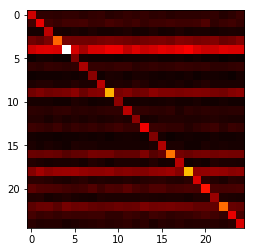

In [145]:
plt.imshow(confusion_matrix(best_choices_25_50, choices_25_50),cmap='hot', interpolation='nearest')

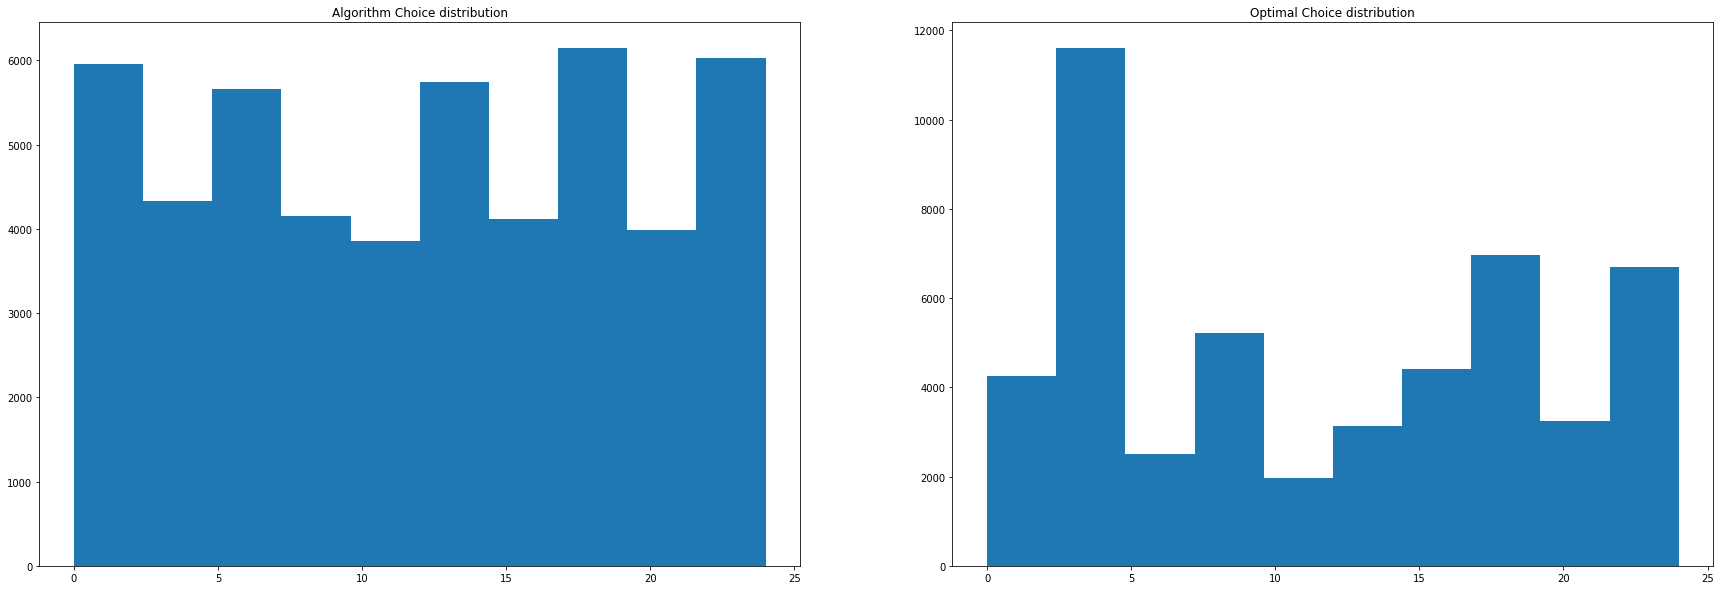

In [146]:
plt.figure(figsize=(20,20))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,10))
ax1.hist(choices_25_50)
ax1.set_title('Algorithm Choice distribution')
ax2.hist(best_choices_25_50) # bins=np.arange(-0.5,8.5))
ax2.set_title('Optimal Choice distribution')
plt.show()

0.16088


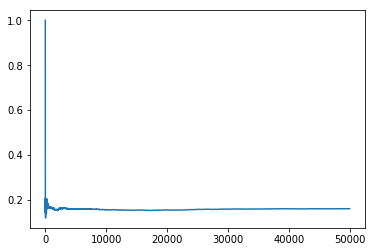

In [148]:
regret_arr_25_50 = np.array(regret_25_50)
print(np.sum(regret_arr_25_50 == 0)/np.size(regret_arr_25_50))
plt.plot(np.cumsum(regret_arr_25_50 == 0)/np.arange(1,T+1))

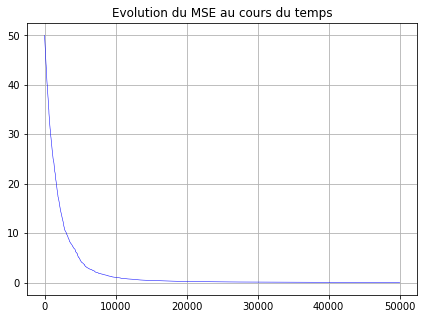

In [150]:
plt.figure(figsize=(7,5))
plt.title('Evolution du MSE au cours du temps')
plt.grid()
plt.plot(MSE_25_50, c='b', linewidth=0.5)

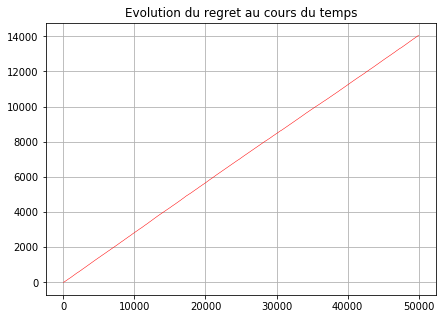

In [151]:
#on affiche le regret
plt.figure(figsize=(7,5))
plt.title('Evolution du regret au cours du temps')
plt.grid()
plt.plot(np.cumsum(np.array(regret_25_50)), c='r', linewidth=0.5)

In [30]:
import random
def dummy(gamma,alpha,d,n,T):
    regret = []
    choices = []
    best_choices = []
    generate_data_tot = generate_data(T= T, n=n, d=d)
    data_generation = generate_data_tot[1]
    for t in range(T):
        #données générées
        i_t, u_i_t,C_t = data_generation[t]
        u_i_t = np.matrix(u_i_t).T
        
        #choix au hasard et regret
        choice = random.randint(0,C_t.shape[1]-1)
        choices += [choice]
        best_choice = np.argmax(u_i_t.T @ C_t)
        best_choices += [np.where(C_t[:, best_choice] == 1.)[0][0]]
        regret += [ float(u_i_t.T*C_t[:, best_choice] - u_i_t.T*C_t[:, choice])]
    return [regret, choices, best_choices]

In [31]:
[regret_dum, choices_dum, best_choices_dum]=dummy(gamma=0.2,alpha= [math.sqrt(d*math.log(t)) for t in range(1,3001)],
                                                          d=d,n=n,T=T)

(array([ 6066.,     0.,     0.,     0.,  2799.,     0.,     0.,     0.,
         1135.]),
 array([ 0.        ,  0.22222222,  0.44444444,  0.66666667,  0.88888889,
         1.11111111,  1.33333333,  1.55555556,  1.77777778,  2.        ]),
 <a list of 9 Patch objects>)

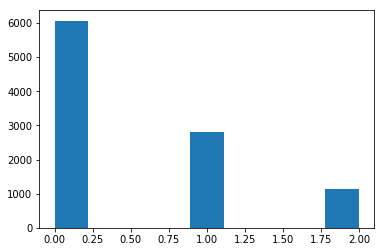

In [33]:
plt.hist(choices_dum, bins=9)

(array([ 2598.,     0.,     0.,  1470.,     0.,     0.,  4074.,     0.,
         1858.]),
 array([ 0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
         1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ]),
 <a list of 9 Patch objects>)

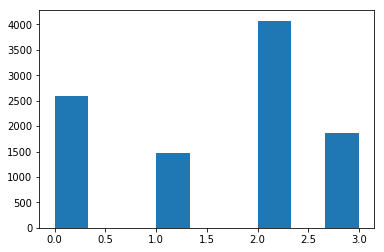

In [34]:
plt.hist(best_choices_dum, bins=9)

In [35]:
print(sum(np.array(best_choices_dum)==0))
confusion_matrix(best_choices_dum, choices_dum)

2598

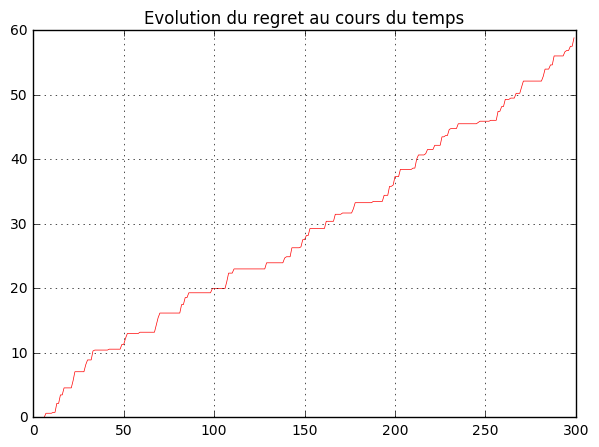

In [75]:
#on affiche le regret
plt.figure(figsize=(7,5))
plt.title('Evolution du regret au cours du temps')
plt.grid()
plt.plot(np.cumsum(np.array(regret_dum)), c='r', linewidth=0.5)

In [217]:
d=15
n=100
T=25000
[u_25_50, w_25_50, regret_25_50, MSE_25_50, choices_25_50, best_choices_25_50, updates, neigh] = Context_Aware_Clustering_of_Bandits_new(
                                            gamma=0.25, alpha= [math.sqrt(math.log(t+1)/(10*d)) for t in range(1,T+1)],
                                            d=d,n=n,T=T, verbose = True)

##################
##################
tour n° 0
##################
##################
sanity check data generation part -----
i_t: 45
CB [[ 0.0679778  0.0679778  0.0679778 ...,  0.0679778  0.0679778  0.0679778]
 [ 0.0679778  0.0679778  0.0679778 ...,  0.0679778  0.0679778  0.0679778]
 [ 0.0679778  0.0679778  0.0679778 ...,  0.0679778  0.0679778  0.0679778]
 ..., 
 [ 0.0679778  0.0679778  0.0679778 ...,  0.0679778  0.0679778  0.0679778]
 [ 0.0679778  0.0679778  0.0679778 ...,  0.0679778  0.0679778  0.0679778]
 [ 0.0679778  0.0679778  0.0679778 ...,  0.0679778  0.0679778  0.0679778]]
@@ Neighborhood Sanity Check @@
Left part of the equation: 0.0
CB[i_t, num_item] + CB[j, num_item]: 0.135955598689
@@ Neighborhood Sanity Check @@
Left part of the equation: 0.0
CB[i_t, num_item] + CB[j, num_item]: 0.135955598689
@@ Neighborhood Sanity Check @@
Left part of the equation: 0.0
CB[i_t, num_item] + CB[j, num_item]: 0.135955598689
@@ Neighborhood Sanity Check @@
Left part of the equation: 0.0
CB[

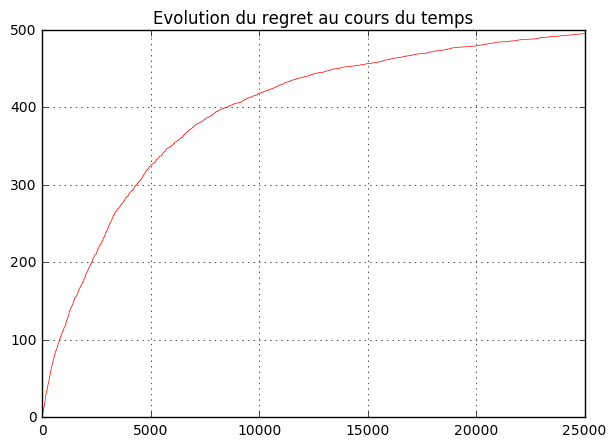

In [206]:
#on affiche le regret
plt.figure(figsize=(7,5))
plt.title('Evolution du regret au cours du temps')
plt.grid()
plt.plot(np.cumsum(np.array(regret_25_50)), c='r', linewidth=0.5)

In [218]:
np.max(updates)

75

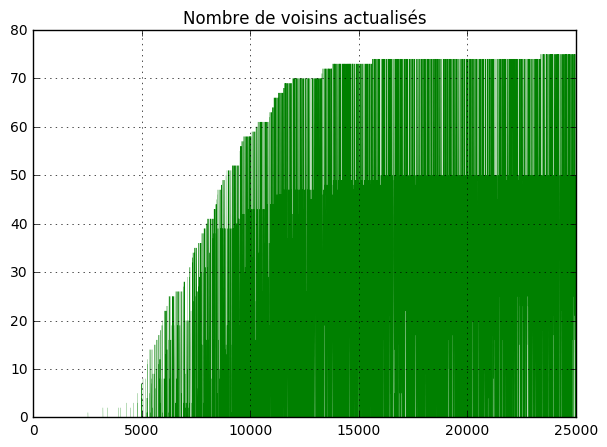

In [219]:
#on affiche les voisins
plt.figure(figsize=(7,5))
plt.title('Nombre de voisins actualisés')
plt.grid()
plt.plot(np.array(updates), c='g', linewidth=0.1)

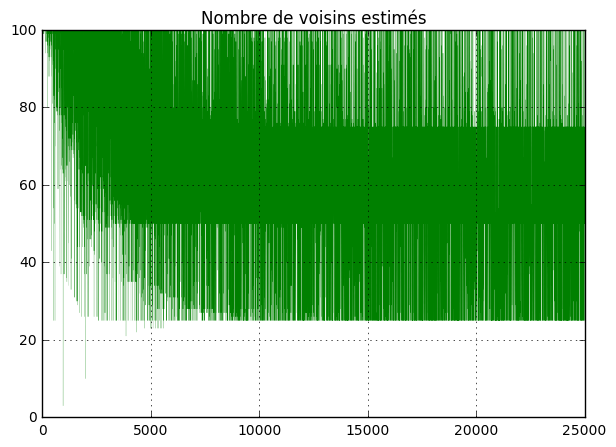

In [220]:
#on affiche les voisins
plt.figure(figsize=(7,5))
plt.title('Nombre de voisins estimés')
plt.grid()
plt.plot(np.array(neigh), c='g', linewidth=0.1)

(array([  8.05000000e+02,   2.00000000e+01,   1.70000000e+01,
          0.00000000e+00,   2.50000000e+01,   8.00000000e+00,
          1.80000000e+01,   0.00000000e+00,   1.10000000e+01,
          4.00000000e+00,   1.20000000e+01,   0.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   7.00000000e+00,   9.00000000e+00,
          2.60000000e+01,   0.00000000e+00,   1.40000000e+01,
          7.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   7.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   4.00000000e+00,
          1.40000000e+01,   0.00000000e+00,   6.00000000e+00,
          1.81000000e+03,   2.30000000e+02,   0.00000000e+00,
          1.09000000e+02,   9.60000000e+01,   3.50000000e+01,
          0.00000000e+00,   2.40000000e+01,   1.70000000e+01,
          5.00000000e+00,   0.00000000e+00,   1.00000000e+01,
          1.70000000e+01,   1.50000000e+01,   0.00000000e+00,
        

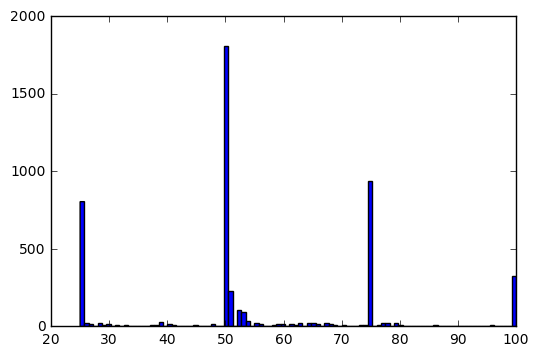

In [221]:
plt.hist(neigh[20000:], bins=100)

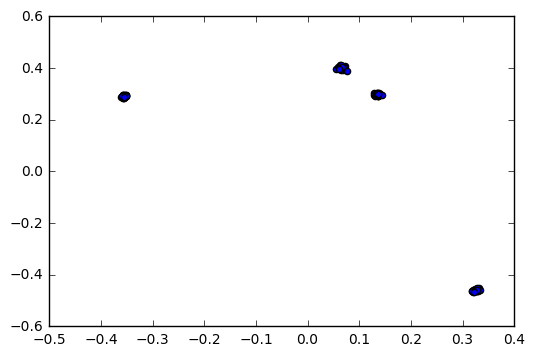

In [204]:
pca = PCA(n_components = 2)

proj = pca.fit_transform(u_25_50)
plt.scatter(u_25_50[:,6].tolist(), u_25_50[:,10].tolist())